In [44]:
import numpy as np
from sklearn.linear_model import Ridge
from scipy.sparse import random
import matplotlib.pyplot as plt
import sdeint

In [50]:
# Параметры резервуара
N = 300  # Размер резервуара
b = 1 
G = 0.3# The strength of the input weights
sparsity = 0.1  # Разреженность 0.1, возможно имелось ввиду 0.9
rho = 0.95 # Спектральный радиус

# Инициализация резервуара
W_res = (random(N, N, density= 0.1).toarray() > 0) * np.random.uniform(-1, 1, (N, N))  # Случайная матрица резервуара
W_res *= rho / np.max(np.abs(np.linalg.eigvals(W_res)))  # Масштабирование спектрального радиуса

W_in = np.zeros((N, 4))
for row in range(N):
    column = np.random.randint(0, 4)
    W_in[row][column] = np.random.uniform(-1, 1)

b = np.random.uniform(-b, b, N)  # Смещение

In [51]:
W_res = np.random.uniform(-1, 1, (N, N))
mask = np.random.rand(N, N) < sparsity  # Sparsity mask
W_res *= mask

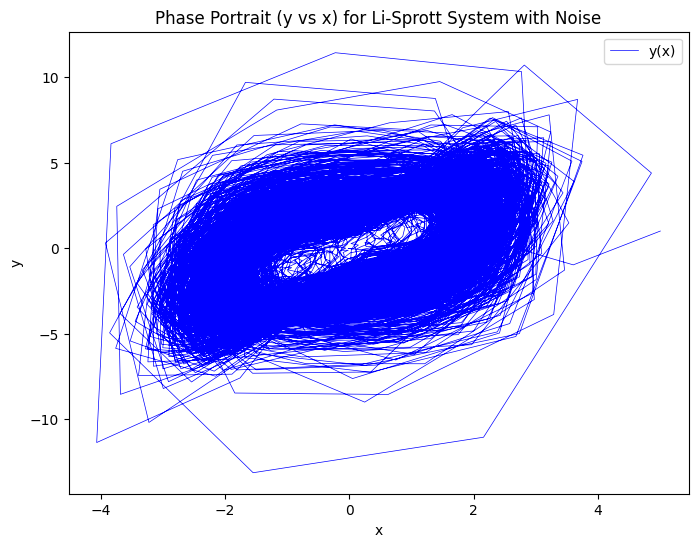

In [46]:
# Параметры системы
a = 2
b = 0.8
sigma = 0.2  # Интенсивность шума (маленькая, как вы указали)

# Функция для системы Ли-Спротта
def LiSprott(X, t):
    x, y, z, u = X
    return np.array([y - x,
                     -a * x * z + u,
                     x * y - a,  # Исправлено на x*y - a
                     -b * y])

# Функция для шума (матрица диффузии)
def GG(X, t):
    return np.diag([sigma] * 4)  # Диагональная матрица с sigma

# Время интегрирования
tspan = np.arange(0, 3300, 0.001)  # Временная сетка

# Начальные условия
start_point = np.array([5, 1, 1, 1])  # Правильные начальные условия

# Решение системы

result = sdeint.itoint(LiSprott, GG, start_point, tspan)

# Визуализация результатов (фазовый портрет y(x))
plt.figure(figsize=(8, 6))
plt.plot(result[::300, 0], result[::300, 1], label="y(x)", color='blue', linewidth=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title('Phase Portrait (y vs x) for Li-Sprott System with Noise')
plt.show()

In [43]:
3300 / 0.001 / 300

11000.0

In [ ]:
# Функция для обновления состояния резервуара
def update_reservoir(state, input_data):
    noise = sigma_noise * np.random.randn(N, 1)  # Случайный шум
    new_state = (1 - alpha) * state + alpha * np.tanh(W_res @ state + W_in @ input_data + b + noise)
    return new_state

# Генерация данных (пример)
def generate_data(length):
    return np.sin(np.linspace(0, 10 * np.pi, length)).reshape(-1, 1)

# Обучение резервуара
def train_reservoir(input_data, target_data, washout=100):
    states = []
    state = np.zeros((N, 1))
    
    for t in range(len(input_data)):
        state = update_reservoir(state, input_data[t])
        if t >= washout:
            states.append(state)
    
    states = np.hstack(states).T
    target_data = target_data[washout:]
    
    # Обучение выходного слоя
    model = Ridge(alpha=1e-6)
    model.fit(states, target_data)
    
    return model, states

# Прогнозирование
def predict(model, initial_state, steps):
    predictions = []
    state = initial_state
    
    for _ in range(steps):
        state = update_reservoir(state, np.zeros((1, 1)))  # Нулевой вход для автономного режима
        predictions.append(model.predict(state.T))
    
    return np.array(predictions)

# Пример использования
input_data = generate_data(1000)
target_data = generate_data(1000)

model, states = train_reservoir(input_data, target_data)

# Прогнозирование на 100 шагов вперёд
predictions = predict(model, states[-1].reshape(-1, 1), 100)

# Визуализация результатов
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(target_data, label="True Data")
plt.plot(np.arange(len(target_data), len(target_data) + 100), predictions, label="Predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("Reservoir Computing: True Data vs Predictions")
plt.show()

In [49]:
import numpy as np
from scipy.integrate import solve_ivp

# Reservoir Computing Parameters
N = 300  # Number of reservoir nodes
rho = 0.1  # Sparsity of the reservoir weight matrix
G = 0.3  # Input gain
b = 1.0  # Bias strength
eta = 1e-3  # Tikhonov regularization strength
theta = 2.5  # Input interval length
T_w = 2500  # Washout time
Re_lambda_max = 0.95  # Maximum eigenvalue of the reservoir

# Initialize Reservoir
def initialize_reservoir(N, rho, G, b, Re_lambda_max):
    # Initialize bias vector
    B = np.random.uniform(-b, b, N)
    
    # Initialize input weight matrix (sparse, one non-zero entry per row)
    W_in = np.zeros((N, 4))
    for i in range(N):
        col = np.random.randint(0, 4)  # Randomly choose a column
        W_in[i, col] = np.random.uniform(-1, 1)  # Random value in [-1, 1]
    W_in *= G  # Scale by input gain
    
    # Initialize reservoir weight matrix (sparse)
    W_res = np.random.uniform(-1, 1, (N, N))
    mask = np.random.rand(N, N) < rho  # Sparsity mask
    W_res *= mask
    
    # Normalize reservoir matrix to have maximum eigenvalue Re_lambda_max
    eigenvalues = np.linalg.eigvals(W_res)
    max_eigenvalue = np.max(np.real(eigenvalues))
    W_res = (Re_lambda_max / max_eigenvalue) * W_res
    
    return W_res, W_in, B

# Reservoir Dynamics
def reservoir_dynamics(t, X, W_res, W_in, B, u_func):
    # Input u_func is a callable function that returns the input at time t
    u_t = u_func(int(t / theta))  # Get the current input value
    dX = -X + np.tanh(W_res @ X + W_in @ u_t + B)
    return dX

# Training the Reservoir
def train_reservoir(W_res, W_in, B, u_train, T_w, eta):
    # Integrate reservoir dynamics using Runge-Kutta
    t_span = (0, T_w + len(u_train) * theta)
    t_eval = np.arange(0, T_w + len(u_train) * theta, theta)
    X0 = np.zeros(N)  # Initial state
    
    # Define a callable function for the input
    u_func = lambda t_idx: u_train[t_idx]
    
    # Solve reservoir dynamics
    sol = solve_ivp(reservoir_dynamics, t_span, X0, args=(W_res, W_in, B, u_func), t_eval=t_eval)
    X = sol.y.T  # Reservoir states over time
    
    # Discard washout period
    X = X[int(T_w / theta):]
    
    # Construct state matrix S with bias term
    S = np.hstack([X, np.ones((X.shape[0], 1))])
    
    # Target matrix Y (one-step-ahead prediction)
    Y = u_train[1:]
    
    # Solve for output weights W_out using Tikhonov regularization
    I = np.eye(N + 1)  # Identity matrix for regularization
    W_out = np.linalg.pinv(S.T @ S + eta * I) @ S.T @ Y
    
    return W_out

# Autonomous Operation
def autonomous_operation(W_res, W_in, B, W_out, u_init, num_steps):
    # Initialize reservoir state
    X = np.zeros(N)
    
    # Warmup with initial transient
    for t in range(len(u_init)):
        u_t = u_init[t]
        X = X + reservoir_dynamics(t * theta, X, W_res, W_in, B, lambda _: u_t) * theta
    
    # Autonomous prediction
    predictions = []
    for _ in range(num_steps):
        # Construct state vector with bias term
        S = np.hstack([X, 1])
        
        # Predict next input
        u_pred = S @ W_out
        predictions.append(u_pred)
        
        # Update reservoir state
        X = X + reservoir_dynamics(0, X, W_res, W_in, B, lambda _: u_pred) * theta
    
    return np.array(predictions)

# Example Usage

# Initialize reservoir
W_res, W_in, B = initialize_reservoir(N, rho, G, b, Re_lambda_max)

# Generate training data (example: Lorenz system or other chaotic system)
# Here, we use random data for demonstration
u_train = np.random.randn(10000, 4)  # Replace with actual training data

# Train reservoir
W_out = train_reservoir(W_res, W_in, B, u_train, T_w, eta)

# Autonomous operation (infer unseen attractors)
u_init = u_train[:1000]  # Initial transient for warmup
predictions = autonomous_operation(W_res, W_in, B, W_out, u_init, num_steps=10000)

print("Predictions shape:", predictions.shape)

IndexError: index 10000 is out of bounds for axis 0 with size 10000